In [ ]:
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import torch.nn.functional as F
from PIL import Image
import cv2
import random
from sklearn.model_selection import train_test_split
import torch.nn.utils.prune as prune
import json
import zipfile
from google.colab import drive

drive.mount('/content/drive')

with zipfile.ZipFile("/content/drive/MyDrive/Yeni WinRAR ZIP arşivi2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

Mounted at /content/drive


resnet 18

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/10]  Train Loss: 1.8002  Val Loss: 0.6077  Time: 24.03s
Epoch [2/10]  Train Loss: 0.5229  Val Loss: 0.3396  Time: 22.40s
Epoch [3/10]  Train Loss: 0.3484  Val Loss: 0.2246  Time: 22.66s
Epoch [4/10]  Train Loss: 0.2542  Val Loss: 0.1906  Time: 22.82s
Epoch [5/10]  Train Loss: 0.2023  Val Loss: 0.1495  Time: 23.23s
Epoch [6/10]  Train Loss: 0.1686  Val Loss: 0.1131  Time: 23.24s
Epoch [7/10]  Train Loss: 0.1440  Val Loss: 0.1853  Time: 22.95s
Epoch [8/10]  Train Loss: 0.1186  Val Loss: 0.1260  Time: 23.45s
Epoch [9/10]  Train Loss: 0.1071  Val Loss: 0.1426  Time: 23.10s
Epoch [10/10] 

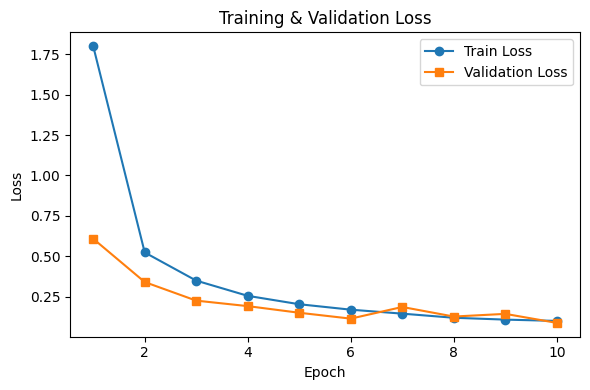


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9497,0.9947,0.9717,190.0
Tomato___Early_blight,0.8824,0.9184,0.9000,98.0
Tomato___Late_blight,0.9444,0.9855,0.9645,207.0
Tomato___Leaf_Mold,1.0000,0.9720,0.9858,107.0
Tomato___Septoria_leaf_spot,1.0000,0.9713,0.9854,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9763,0.9538,0.9649,173.0
Tomato___Target_Spot,0.9481,0.8889,0.9176,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9981,0.9885,0.9933,524.0
Tomato___Tomato_mosaic_virus,0.9406,1.0000,0.9694,95.0
Tomato___healthy,0.9934,0.9804,0.9868,153.0



✅ Genel Accuracy: 0.9716


<ipython-input-2-3125927375c1>:158: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


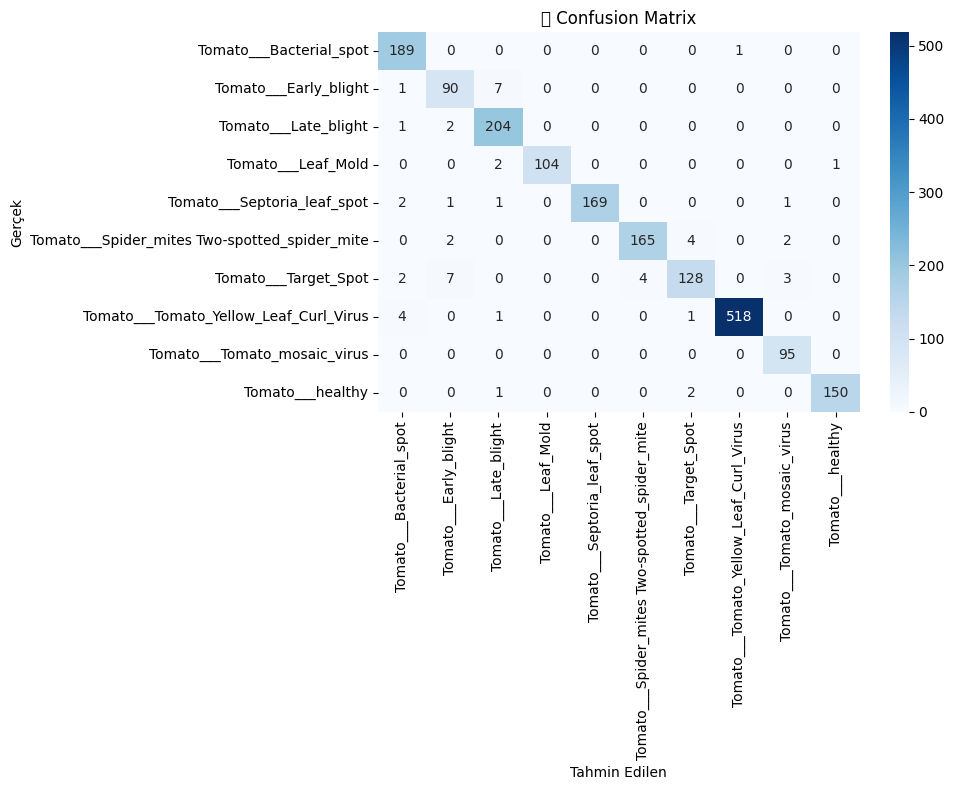

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model1 = timm.create_model('resnet18', pretrained=False)
in_features = model1.num_features if hasattr(model1, 'num_features') else model1.head.in_features
model1.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 10
train_losses = []
val_losses   = [] # Burası artık VALIDATION loss'larını tutacak

for epoch in range(1, epochs+1):
    # -- Train --
    model1.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model1.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}"
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
plt.figure(figsize=(6,4))
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model1.state_dict(), "resnet18.pth")

# --- 6) Son test & rapor ---
model1.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

şimdi resnet 34

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/10]  Train Loss: 1.6467  Val Loss: 0.5176  Time: 36.72s
Epoch [2/10]  Train Loss: 0.4157  Val Loss: 0.3378  Time: 36.53s
Epoch [3/10]  Train Loss: 0.2863  Val Loss: 0.2273  Time: 36.51s
Epoch [4/10]  Train Loss: 0.2237  Val Loss: 0.1851  Time: 36.67s
Epoch [5/10]  Train Loss: 0.1938  Val Loss: 0.1487  Time: 36.52s
Epoch [6/10]  Train Loss: 0.1568  Val Loss: 0.1280  Time: 36.52s
Epoch [7/10]  Train Loss: 0.1423  Val Loss: 0.1162  Time: 36.48s
Epoch [8/10]  Train Loss: 0.1166  Val Loss: 0.0901  Time: 36.59s
Epoch [9/10]  Train Loss: 0.1018  Val Loss: 0.1082  Time: 36.57s
Epoch [10/10] 

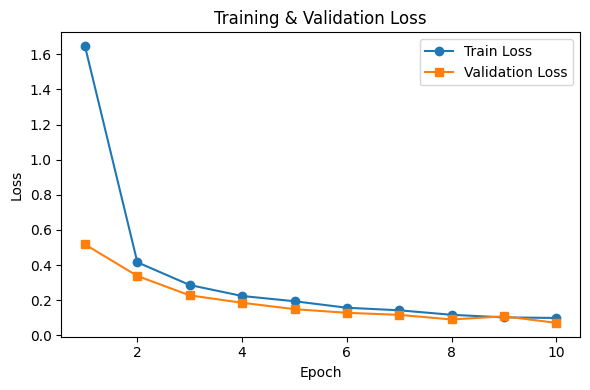


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9588,0.9789,0.9688,190.0
Tomato___Early_blight,0.9468,0.9082,0.9271,98.0
Tomato___Late_blight,0.9579,0.9903,0.9739,207.0
Tomato___Leaf_Mold,0.9906,0.9813,0.9859,107.0
Tomato___Septoria_leaf_spot,1.0000,0.9885,0.9942,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9641,0.9306,0.9471,173.0
Tomato___Target_Spot,0.9496,0.9167,0.9329,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9849,0.9981,0.9915,524.0
Tomato___Tomato_mosaic_virus,0.9895,0.9895,0.9895,95.0
Tomato___healthy,1.0000,1.0000,1.0000,153.0



✅ Genel Accuracy: 0.9759


<ipython-input-3-fe632dc5e2f8>:158: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


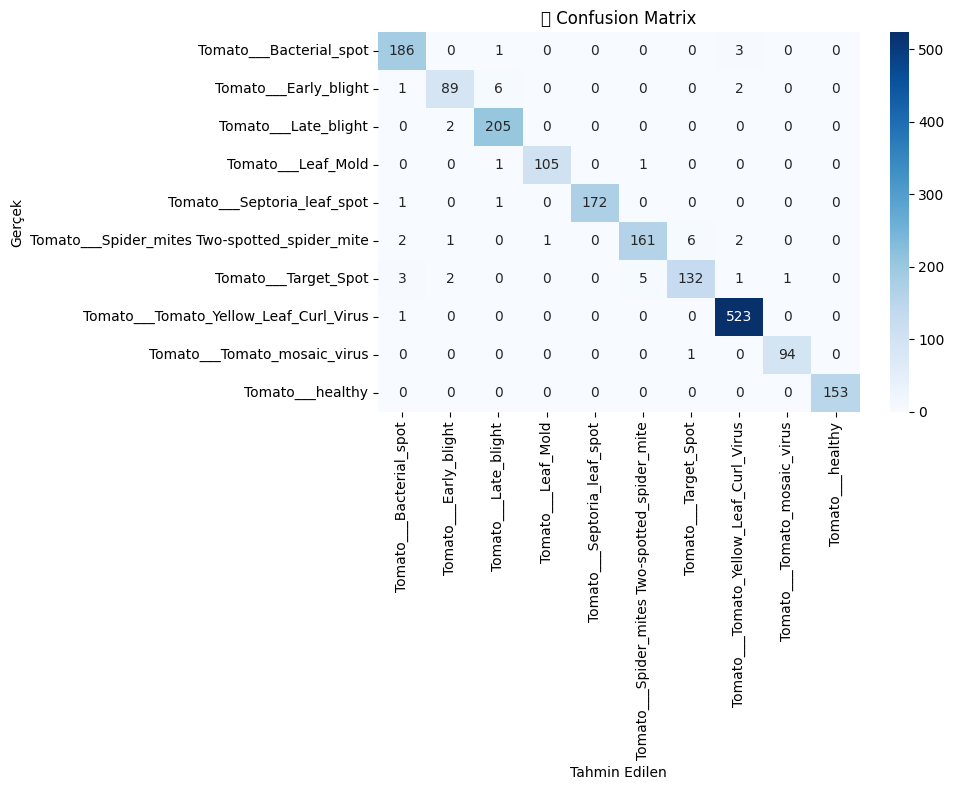

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model2 = timm.create_model('resnet34', pretrained=False)
in_features = model2.num_features if hasattr(model2, 'num_features') else model2.head.in_features
model2.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 10
train_losses = []
val_losses   = [] # Burası artık VALIDATION loss'larını tutacak

for epoch in range(1, epochs+1):
    # -- Train --
    model2.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader: # <<< Burayı val_loader olarak değiştirin
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader) # <<< Burayı len(val_loader) olarak değiştirin

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}" # Bu çıktı artık VALIDATION loss'unu gösterecek
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss) # Burası artık VALIDATION loss'larını tutacak

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
# Bu bölümün başlığı "Training & Validation Loss" olarak kalabilir veya "Training & Evaluation Loss" olarak değiştirilebilir,
# çünkü 'Val Loss' artık validasyon setinin performansını gösteriyor.
plt.figure(figsize=(6,4))
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Validation Loss') # Legend'ı "Validation Loss" olarak değiştirebilirsiniz
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss') # Başlık da aynı şekilde
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model2.state_dict(), "resnet34.pth")

# --- 6) Son test & rapor ---
model2.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Raporlama ve Confusion Matrix oluşturma kısmı aynı kalır,
# çünkü all_preds ve all_labels artık yeni test setinin sonuçlarını içerecek.
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

şimdi de resnet50

Sınıf sayısı: 10
Sınıflar: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Eğitim set boyutu: 15083
Test set boyutu:   1865
Validasyon set boyutu: 1887
Epoch [1/10]  Train Loss: 0.9100  Val Loss: 0.3800  Time: 74.81s
Epoch [2/10]  Train Loss: 0.3656  Val Loss: 0.2666  Time: 74.46s
Epoch [3/10]  Train Loss: 0.2591  Val Loss: 0.2164  Time: 74.44s
Epoch [4/10]  Train Loss: 0.2000  Val Loss: 0.1984  Time: 74.44s
Epoch [5/10]  Train Loss: 0.1578  Val Loss: 0.1516  Time: 74.44s
Epoch [6/10]  Train Loss: 0.1329  Val Loss: 0.1059  Time: 74.40s
Epoch [7/10]  Train Loss: 0.1134  Val Loss: 0.1024  Time: 74.34s
Epoch [8/10]  Train Loss: 0.0941  Val Loss: 0.1193  Time: 74.40s
Epoch [9/10]  Train Loss: 0.0823  Val Loss: 0.1356  Time: 74.47s
Epoch [10/10] 

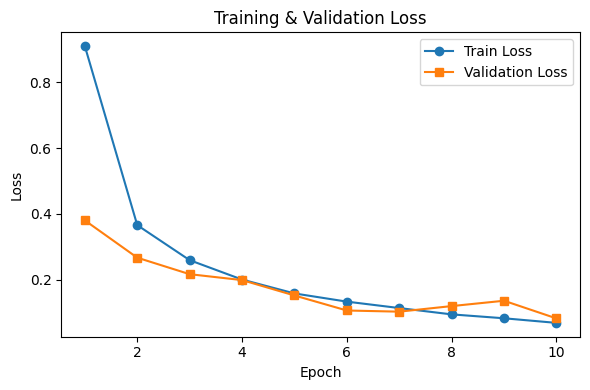


📊 Sınıflandırma Raporu (Tablo Formatında):


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.9261,0.9895,0.9567,190.0
Tomato___Early_blight,0.9278,0.9184,0.9231,98.0
Tomato___Late_blight,0.9949,0.9372,0.9652,207.0
Tomato___Leaf_Mold,0.9907,0.9907,0.9907,107.0
Tomato___Septoria_leaf_spot,0.9769,0.9713,0.9741,174.0
Tomato___Spider_mites Two-spotted_spider_mite,0.9432,0.9595,0.9513,173.0
Tomato___Target_Spot,0.9060,0.9375,0.9215,144.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.9943,0.9905,0.9924,524.0
Tomato___Tomato_mosaic_virus,1.0000,0.9579,0.9785,95.0
Tomato___healthy,1.0000,0.9935,0.9967,153.0



✅ Genel Accuracy: 0.9705


<ipython-input-4-f9dfa391caec>:158: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


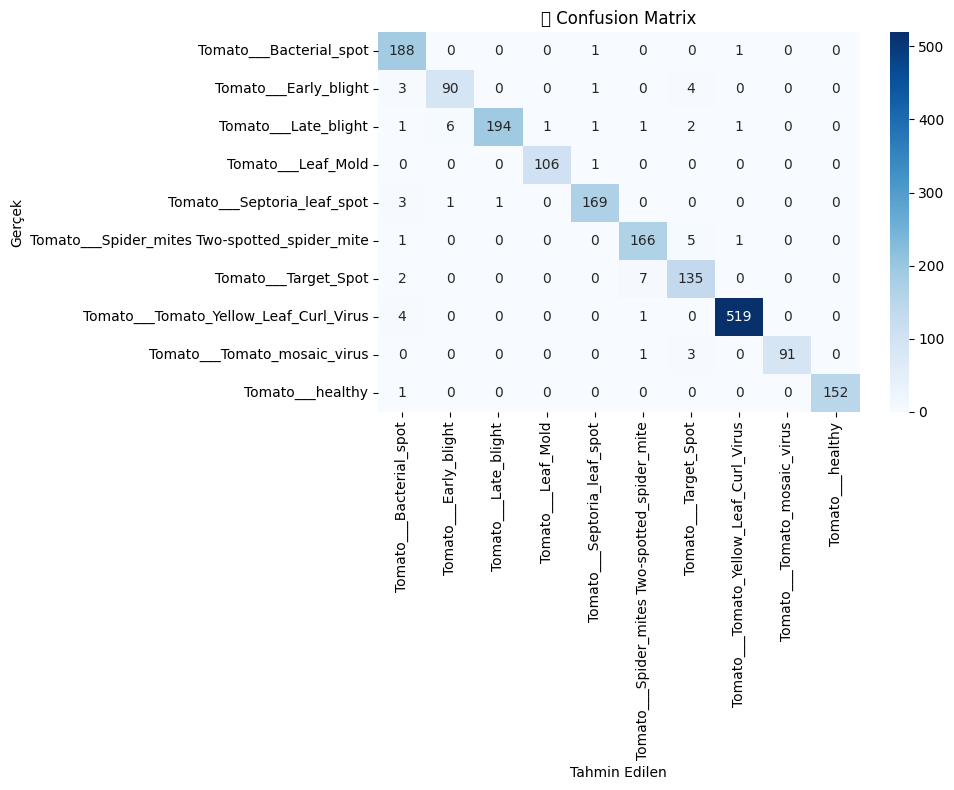

In [ ]:
# --- 1) Cihaz ve veri hazırlıkları ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_test_dir = "/content/augmentation"
val_dir  = "/content/without_augmentation"
img_size  = 224
batch_size = 32
train_test_ratio = 0.89

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

full_train_test_dataset = datasets.ImageFolder(train_test_dir, transform=train_transforms)

# Dataseti train ve test setlerine ayır
train_size = int(train_test_ratio * len(full_train_test_dataset))
test_size  = len(full_train_test_dataset) - train_size
train_dataset, test_dataset = train_test_split(full_train_test_dataset, train_size=train_size, random_state=42)

# Val dataseti yükle (artık test_dir olarak tanımlanan yerden)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Validasyon DataLoader'ı

# Sınıf isimleri ve sayısı hala train_test_dir'den geliyor
class_names = full_train_test_dataset.classes
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}\nSınıflar: {class_names}")
print(f"Eğitim set boyutu: {len(train_dataset)}")
print(f"Test set boyutu:   {len(test_dataset)}")
print(f"Validasyon set boyutu: {len(val_dataset)}")

# --- 2) Model, loss, optimizer ---
model3 = timm.create_model('resnet50', pretrained=False)
in_features = model3.num_features if hasattr(model3, 'num_features') else model3.head.in_features
model3.head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(in_features, num_classes)
)
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4)

# --- 3) Eğitim + Validation döngüsü ---
epochs = 10
train_losses = []
val_losses   = [] # Burası artık VALIDATION loss'larını tutacak

for epoch in range(1, epochs+1):
    # -- Train --
    model3.train()
    running_train_loss = 0.0
    t0 = time.time()

    for images, labels in train_loader: # Train loader kullanılır
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)

    # -- Validation --
    model3.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader: # <<< Burayı val_loader olarak değiştirin
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader) # <<< Burayı len(val_loader) olarak değiştirin

    elapsed = time.time() - t0
    print(f"Epoch [{epoch}/{epochs}]"
          f"  Train Loss: {avg_train_loss:.4f}"
          f"  Val Loss: {avg_val_loss:.4f}" # Bu çıktı artık VALIDATION loss'unu gösterecek
          f"  Time: {elapsed:.2f}s")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss) # Burası artık VALIDATION loss'larını tutacak

# --- 4) Eğitim bittikten sonra Loss eğrilerini çiz ---
# Bu bölümün başlığı "Training & Validation Loss" olarak kalabilir veya "Training & Evaluation Loss" olarak değiştirilebilir,
# çünkü 'Val Loss' artık validasyon setinin performansını gösteriyor.
plt.figure(figsize=(6,4))
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses,   marker='s', label='Validation Loss') # Legend'ı "Validation Loss" olarak değiştirebilirsiniz
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss') # Başlık da aynı şekilde
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Model kaydet ---
torch.save(model3.state_dict(), "resnet50.pth")

# --- 6) Son test & rapor ---
model3.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Raporlama ve Confusion Matrix oluşturma kısmı aynı kalır,
# çünkü all_preds ve all_labels artık yeni test setinin sonuçlarını içerecek.
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

if 'accuracy' in report_df.index:
    accuracy_row = report_df.loc[['accuracy']]
    report_df = report_df.drop(index='accuracy')

# Son tabloyu göster
print("\n📊 Sınıflandırma Raporu (Tablo Formatında):")
display(report_df)

print(f"\n✅ Genel Accuracy: {report['accuracy']:.4f}")

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('📉 Confusion Matrix')
plt.tight_layout()
plt.show()

📊 Evaluating ResNet18...
📊 Evaluating ResNet34...
📊 Evaluating ResNet50...

📈 Karşılaştırmalı Sınıflandırma Performansı:


,Model,Precision,Recall,F1-Score,Accuracy
0,ResNet18,0.9722,0.9716,0.9716,0.9716
1,ResNet34,0.9758,0.9759,0.9757,0.9759
2,ResNet50,0.9713,0.9705,0.9706,0.9705


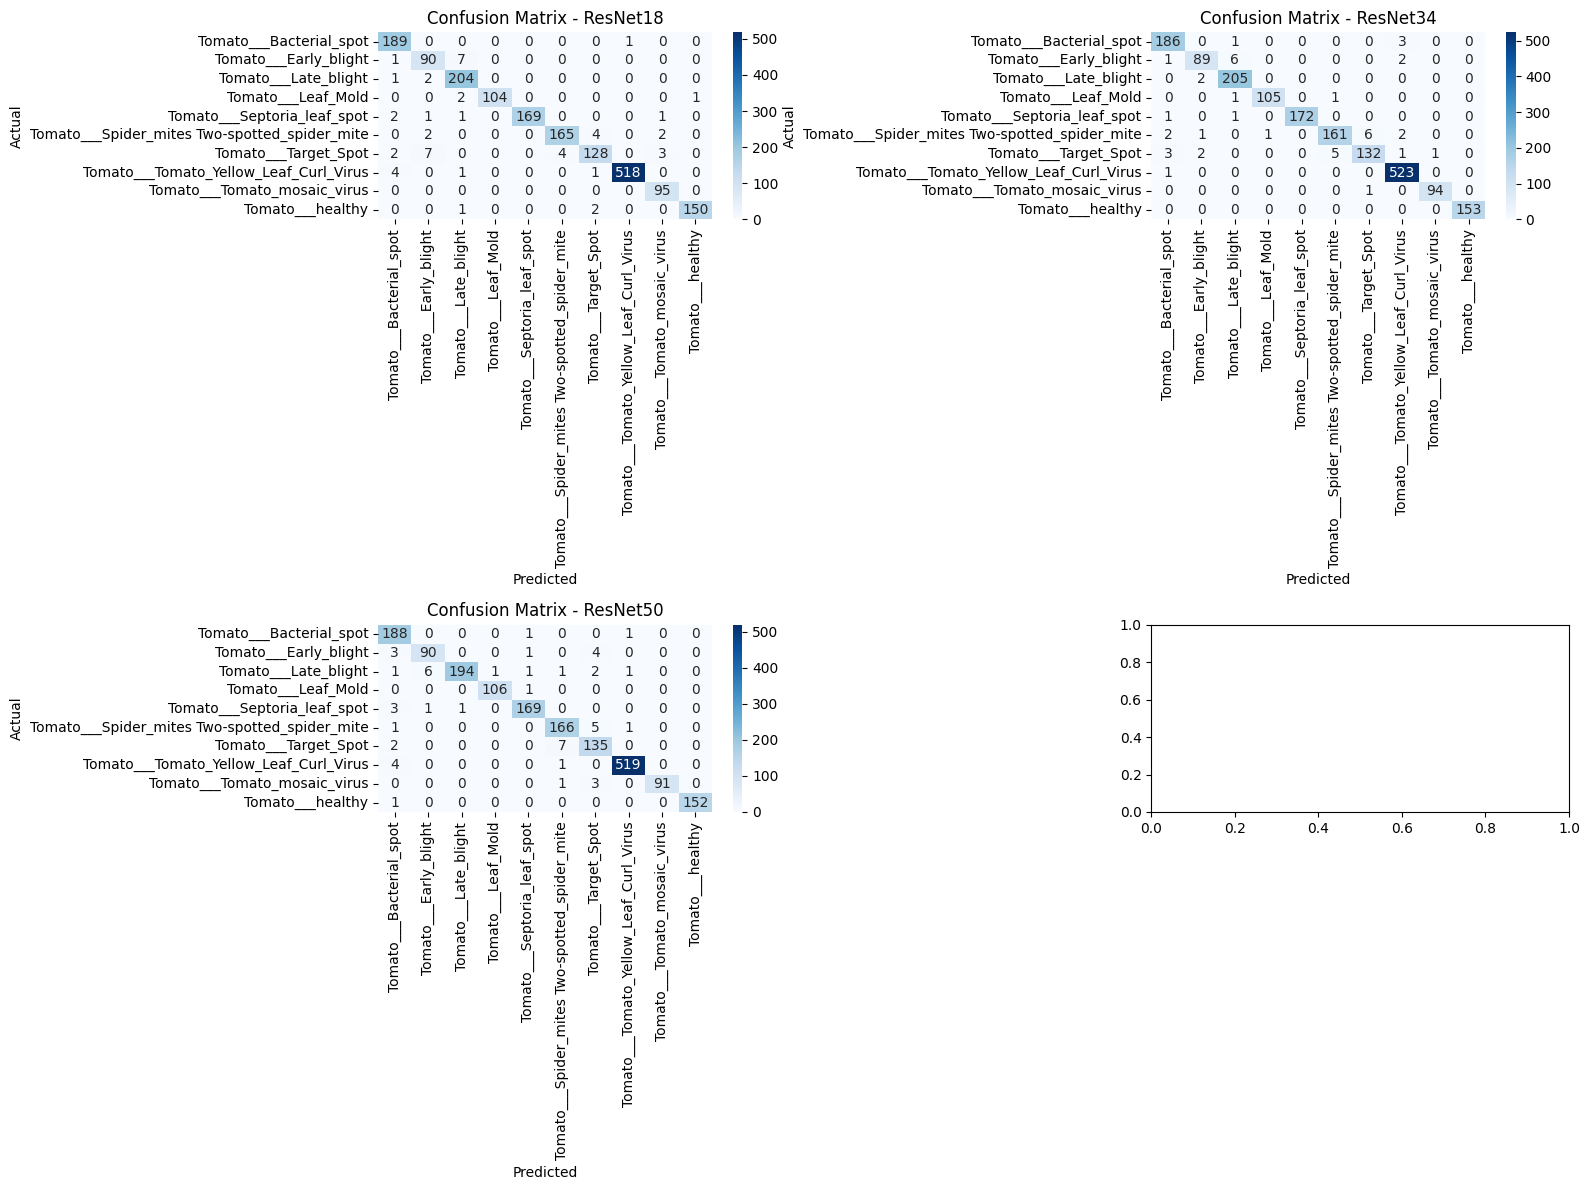

In [ ]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        output_dict=True
    )

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    return report, cm

    # Değerlendirmeyi yapacağımız modeller
models = {
    "ResNet18": model1,
    "ResNet34": model2,
    "ResNet50": model3
}

reports = {}
conf_matrices = {}

for name, model in models.items():
    print(f"📊 Evaluating {name}...")
    report, cm = evaluate_model(model, test_loader, class_names, device)
    reports[name] = report
    conf_matrices[name] = cm

    # Her model için weighted avg (veya macro avg) precision, recall, f1-score değerlerini toplayalım
summary_data = []

for name, report in reports.items():
    row = {
        "Model": name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Accuracy": report["accuracy"]
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("\n📈 Karşılaştırmalı Sınıflandırma Performansı:")
display(summary_df)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

burada da semantic dictionary metodunu test ediyorum, 10 farklı sınıfın her biri için anlamlı channel'ları tespit ediyorum.

In [ ]:
models_path_list = ["/content/resnet18.pth", "/content/resnet34.pth", "/content/resnet50.pth"]
models_name_list = ["resnet18", "resnet34", "resnet50"]
important_channels_combined = []

for models_name in models_name_list:
  for models_path in models_path_list:
    if models_name in models_path:

      #semantic veriyi liste olarak kaydettiğim, yani 50 channelın tamamını classına bakmaksızın kaydediyoruz
      # Modeli doğru sınıf sayısıyla başlat
      model = timm.create_model(models_name, pretrained=False, num_classes=10)

      # Ağırlıkları yüklemeden önce state_dict'i oku
      state_dict = torch.load(models_path, map_location=torch.device("cpu"))

      # ❌ FC katmanı ağırlıklarını çıkar
      state_dict = {k: v for k, v in state_dict.items() if not k.startswith("fc.")}

      # Geri kalan ağırlıkları yükle (strict=False gerekmez artık)
      model.load_state_dict(state_dict, strict=False)
      model.eval()

      # 🧠 GAP öncesi son conv katmanını bul
      if models_name == "resnet18" or models_name == "resnet34":
        target_layer = model.layer4[-1].conv2
      else:
        target_layer = model.layer4[-1].conv3
      feature_maps = []

      def forward_hook(module, input, output):
          feature_maps.append(output.detach())

      hook_handle = target_layer.register_forward_hook(forward_hook)

      # 📂 Validation verisini yükle
      data_dir = "/content/without_augmentation"
      transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
      dataset = datasets.ImageFolder(data_dir, transform=transform)
      dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
      class_names = dataset.classes

      # 🔍 Her örnek için gerçek etiketli feature map katkısını al
      semantic_dict = {}              # {class_idx: [channel_contributions]}
      important_channels_set = set() # ❗ Tüm sınıfların önemli kanallarını saklayan set

      for img_tensor, label in dataloader:
          feature_maps.clear()
          output = model(img_tensor)

          true_class = label.item()  # gerçek sınıf etiketi
          weights = model.fc.weight[true_class]  # sınıfa özel FC ağırlıkları

          fmap = feature_maps[0]            # (1, C, H, W)
          fmap = fmap.squeeze(0)            # (C, H, W)
          pooled = torch.mean(fmap.view(fmap.shape[0], -1), dim=1)  # GAP: (C,)

          contribution = pooled * weights   # kanal katkı değeri (C,)

          if true_class not in semantic_dict:
              semantic_dict[true_class] = []

          semantic_dict[true_class].append(contribution.detach().cpu().numpy())

      # 📊 Her sınıf için ortalama katkı vektörünü yazdır + önemli kanalları topla
      for cls, contribs in semantic_dict.items():
          contribs = np.stack(contribs)
          mean_contrib = np.mean(contribs, axis=0)
          top_channels = np.argsort(-mean_contrib)[:5]  # en büyük 5 kanal

          #print(f"\n🔸 Sınıf: {class_names[cls]} (Index {cls}) için en anlamlı 5 kanal:")
          for idx in top_channels:
          #    print(f"   Kanal {idx}: katkı = {mean_contrib[idx]:.4f}")
              important_channels_set.add(idx)  # ✅ Tekrarsız olarak ekle

      # ✅ Tüm önemli kanalları topla ve sırala
      important_channels = sorted(list(important_channels_set))
      print(f"\n📦 Tüm sınıflarda öne çıkan toplam {len(important_channels)} kanal:")
      print(important_channels)
      important_channels_combined.append(important_channels)

  print(important_channels_combined)


📦 Tüm sınıflarda öne çıkan toplam 43 kanal:
[np.int64(13), np.int64(29), np.int64(48), np.int64(55), np.int64(57), np.int64(63), np.int64(65), np.int64(77), np.int64(80), np.int64(85), np.int64(112), np.int64(124), np.int64(135), np.int64(136), np.int64(151), np.int64(157), np.int64(166), np.int64(175), np.int64(182), np.int64(186), np.int64(236), np.int64(248), np.int64(253), np.int64(258), np.int64(285), np.int64(286), np.int64(290), np.int64(330), np.int64(354), np.int64(364), np.int64(382), np.int64(389), np.int64(394), np.int64(396), np.int64(398), np.int64(417), np.int64(451), np.int64(463), np.int64(469), np.int64(471), np.int64(475), np.int64(481), np.int64(510)]
[[np.int64(13), np.int64(29), np.int64(48), np.int64(55), np.int64(57), np.int64(63), np.int64(65), np.int64(77), np.int64(80), np.int64(85), np.int64(112), np.int64(124), np.int64(135), np.int64(136), np.int64(151), np.int64(157), np.int64(166), np.int64(175), np.int64(182), np.int64(186), np.int64(236), np.int64(248